# Notebook to analyse the ROMS output

Variables: sea level, temperature, salinity, u&v-current



In [42]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import geopy.distance

In [43]:
# Import data

north_sea4_avg = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/run2/NorthSea4_avg.nc')
ora20c = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ORA20C/forcing input/ora20c.nc')


In [44]:
# Sort coordinates in increasing order
north_sea4_avg = north_sea4_avg.sortby(['ocean_time'])
ora20c = ora20c.sortby(['time', 'depth', 'latitude', 'longitude'])

# Remove years before 1950
north_sea4_avg = north_sea4_avg.where(north_sea4_avg.ocean_time.dt.year > 1949, drop = True)
ora20c = ora20c.where(ora20c.time.dt.year > 1949, drop = True)

# Remove data after 1988
north_sea4_avg = north_sea4_avg.where(north_sea4_avg.ocean_time.dt.year < 1989, drop = True)
ora20c = ora20c.where(ora20c.time.dt.year < 1989, drop = True)

# Obtain monthly and yearly averages
north_sea4_avgm = north_sea4_avg.resample(ocean_time='1M').mean()
north_sea4_avgy = north_sea4_avg.resample(ocean_time='1Y').mean()


ora20cm = ora20c.resample(time='1M').mean()
ora20cy = ora20c.resample(time='1Y').mean()


In [45]:
# Create new dataset of sea level, temperature and salinity with dimensions s_rho, lat and lon

data_vars = dict(zeta=(["time", "latitude", "longitude"], north_sea4_avgm.zeta.values),
                temp=(["time", "s_rho", "latitude", "longitude"], north_sea4_avgm.temp.values),
                salt=(["time", "s_rho", "latitude", "longitude"], north_sea4_avgm.salt.values),)

coords = dict(time=(["time"], north_sea4_avgm.ocean_time.values),
             s_rho=(["s_rho"], north_sea4_avgm.s_rho.values),
             latitude=(["latitude"], north_sea4_avgm.lat_rho.values[:,0]),
             longitude=(["longitude"], north_sea4_avgm.lon_rho.values[0]))



roms_monthly = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )

# Create new dataset of sea level, temperature and salinity with dimensions s_rho, lat and lon

data_vars = dict(zeta=(["time", "latitude", "longitude"], north_sea4_avgy.zeta.values),
                temp=(["time", "s_rho", "latitude", "longitude"], north_sea4_avgy.temp.values),
                salt=(["time", "s_rho", "latitude", "longitude"], north_sea4_avgy.salt.values),)

coords = dict(time=(["time"], north_sea4_avgy.ocean_time.values),
             s_rho=(["s_rho"], north_sea4_avgy.s_rho.values),
             latitude=(["latitude"], north_sea4_avgy.lat_rho.values[:,0]),
             longitude=(["longitude"], north_sea4_avgy.lon_rho.values[0]))



roms_yearly = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )


# Create new dataset of sea level, temperature and salinity with dimensions s_rho, lat and lon

data_vars = dict(zeta=(["time", "latitude", "longitude"], north_sea4_avg.zeta.values),
                temp=(["time", "s_rho", "latitude", "longitude"], north_sea4_avg.temp.values),
                salt=(["time", "s_rho", "latitude", "longitude"], north_sea4_avg.salt.values),
                h=(["latitude", "longitude", "time"], north_sea4_avg.h.values),)

coords = dict(time=(["time"], north_sea4_avg.ocean_time.values),
             s_rho=(["s_rho"], north_sea4_avg.s_rho.values),
             latitude=(["latitude"], north_sea4_avg.lat_rho.values[:,0]),
             longitude=(["longitude"], north_sea4_avg.lon_rho.values[0]))



roms_rho = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )


data_vars = dict(ubar=(["time", "latitude", "longitude"], north_sea4_avg.ubar.values),)

coords = dict(time=(["time"], north_sea4_avg.ocean_time.values),
             latitude=(["latitude"], north_sea4_avg.lat_u.values[:,0]),
             longitude=(["longitude"], north_sea4_avg.lon_u.values[0]))



roms_u = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )


data_vars = dict(vbar=(["time", "latitude", "longitude"], north_sea4_avg.vbar.values),)

coords = dict(time=(["time"], north_sea4_avg.ocean_time.values),
             latitude=(["latitude"], north_sea4_avg.lat_v.values[:,0]),
             longitude=(["longitude"], north_sea4_avg.lon_v.values[0]))



roms_v = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )

In [46]:
# Import tide gauge locations

def station_coords(): 
    """
    Function to obtain the coordinates of the tide gauge stations as a dataframe
    
    """
    path_slh = '/Users/iriskeizer/Documents/ROMS/data/'
    stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Brest', 'Sheerness', 'Cuxhaven']
    
    # Necessary declarations to obtain tide gauge station coordinates
    path_locations = path_slh + 'rlr_annual/filelist.txt'
    loc_num = [20, 22, 23, 24, 25, 32, 1, 3, 7]
    col_names = ['id', 'lat', 'lon', 'station', 'coastline_code', 'station_code', 'quality']
    
    # Create dataframe
    df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    df = df.set_index('id')
    df = df.loc[loc_num, :]
    df['station'] = stations
    df = df.set_index('station')
    df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)
    
    return df

tg_coords = station_coords()

In [47]:
tg_coords

,lat,lon
station,,
Vlissingen,51.442222,3.596111
Hoek v. Holland,51.977500,4.120000
Den Helder,52.964444,4.745000
Delfzijl,53.326389,6.933056
Harlingen,53.175556,5.409444
IJmuiden,52.462222,4.554722
Brest,48.382850,-4.494838
Sheerness,51.445639,0.743444
Cuxhaven,53.866667,8.716667


## Compare sea level

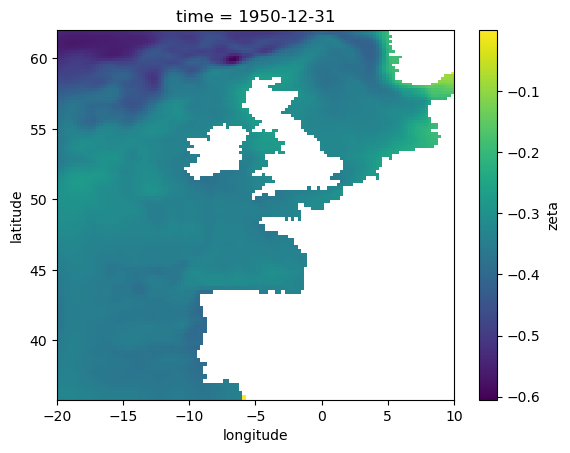

In [48]:
roms_yearly.zeta.isel(time=0).plot()

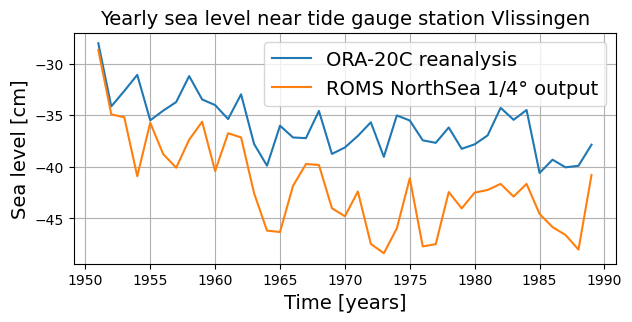

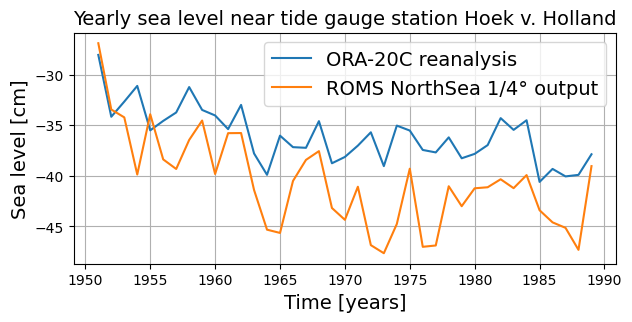

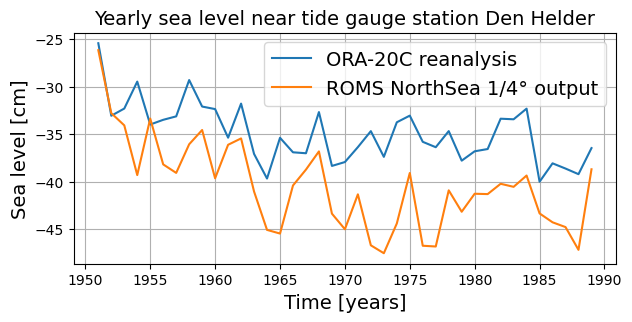

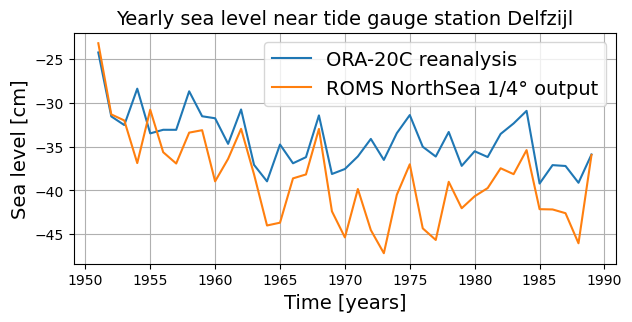

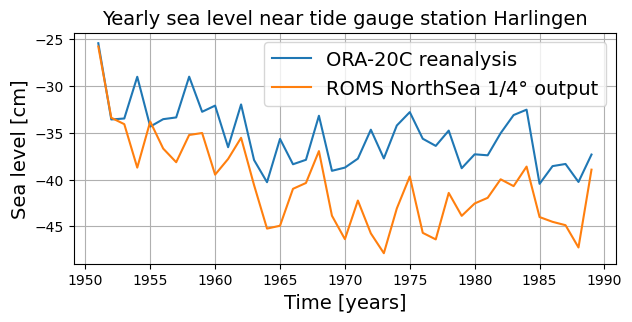

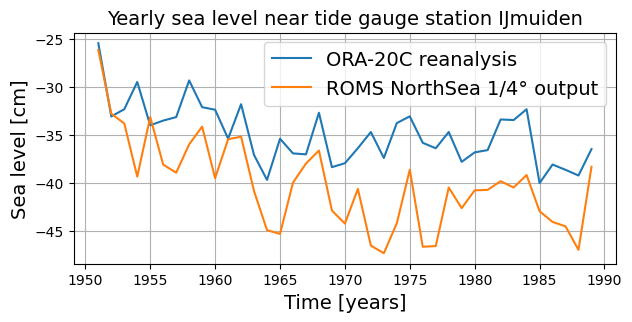

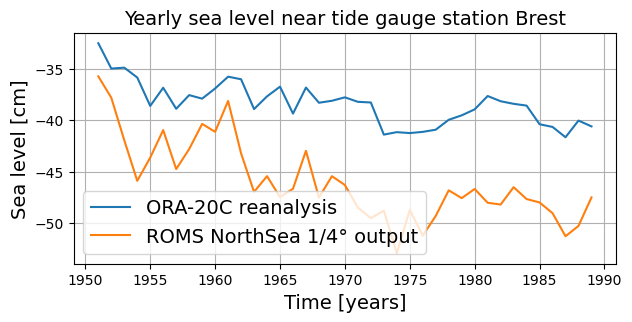

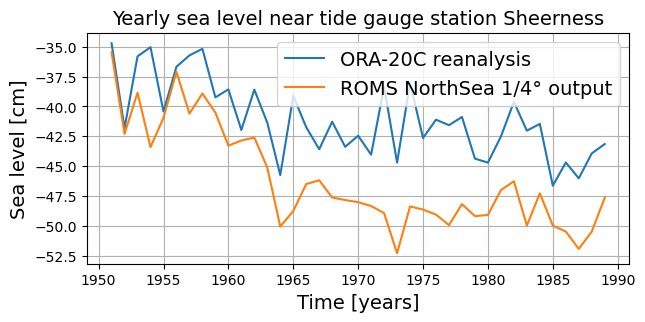

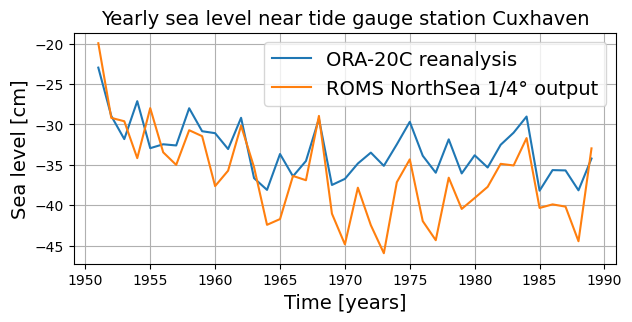

In [49]:
stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Brest', 'Sheerness', 'Cuxhaven']

for station in stations:

    plt.figure(figsize = (7,3))

    
    # Select data near station
    if station == 'Vlissingen':
        
        ora_station = ora20cy.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_yearly.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        
    elif station == 'Hoek v. Holland':
        
        ora_station = ora20cy.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.2, method = 'Nearest')
        roms_station = roms_yearly.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        
    elif station == 'Den Helder':
        
        ora_station = ora20cy.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_yearly.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
            
    elif station == 'Delfzijl': 
        
        ora_station = ora20cy.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_yearly.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
    
    elif station == 'Harlingen': 
        
        ora_station = ora20cy.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_yearly.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
           
    elif station == 'Brest': 
        
        ora_station = ora20cy.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_yearly.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
           
    elif station == 'Sheerness': 
        
        ora_station = ora20cy.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_yearly.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
    
    elif station == 'Cuxhaven': 
        
        ora_station = ora20cy.sel(latitude = tg_coords['lat'][station]+0.5, longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_yearly.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        
    else:
         
        ora_station = ora20cy.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_yearly.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')

    # Make data shorter period
    ora_station = ora_station.where((ora_station.time.dt.year > 1949) & (ora_station.time.dt.year < 1991), drop = True)
   

    # Plot data
    plt.plot(ora_station.time, ora_station.zos*100)
    plt.plot(roms_station.time, roms_station.zeta*100)


    # Format figure
    fsize = 14

    plt.xlabel('Time [years]', fontsize = fsize)
    plt.ylabel('Sea level [cm]', fontsize = fsize)
    plt.title(f'Yearly sea level near tide gauge station {station}', fontsize = fsize)

    #plt.xlim([1950, 2020])
    #plt.xticks([1960, 1980, 2000, 2020], fontsize = fsize)
    #plt.yticks([-40, -20], fontsize = fsize)

    plt.grid()


    # Add legend
    plt.legend(labels = ['ORA-20C reanalysis', 'ROMS NorthSea 1/4° output'], fontsize = fsize)

    if station == 'Hoek v. Holland':
        plt.savefig(f'figures/ora_roms_tidegauges_HoekvHolland')
    else:
        plt.savefig(f'figures/ora_roms_tidegauges_{station}')


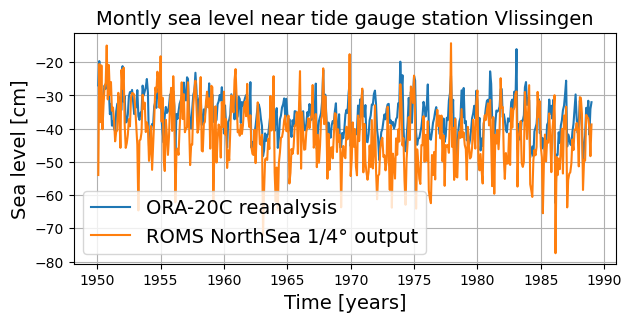

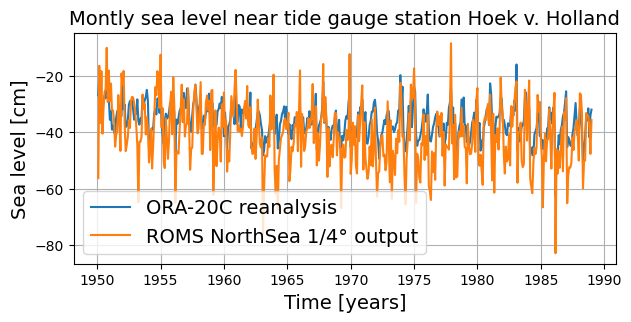

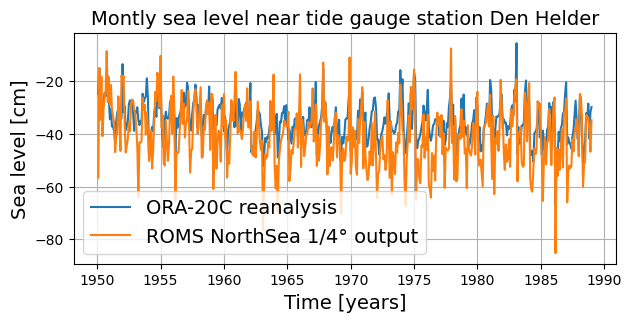

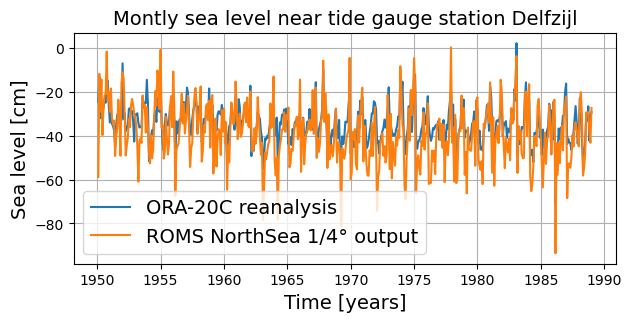

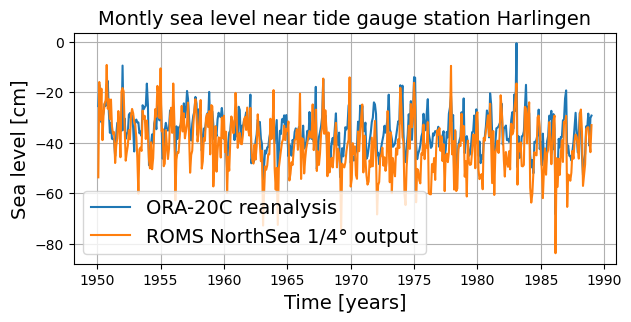

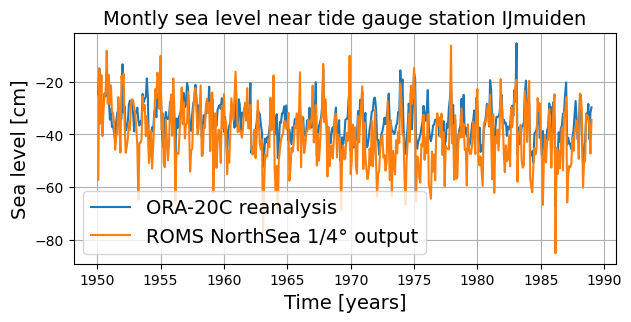

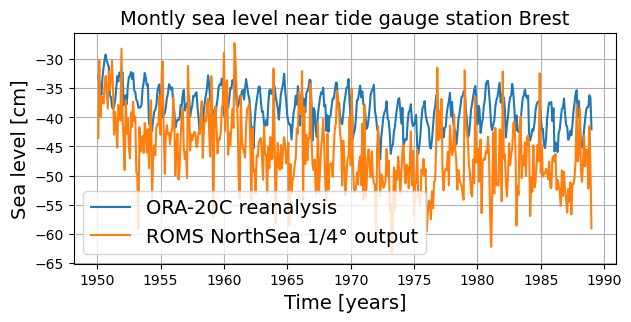

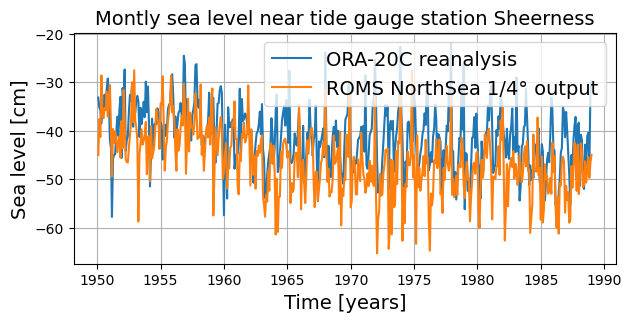

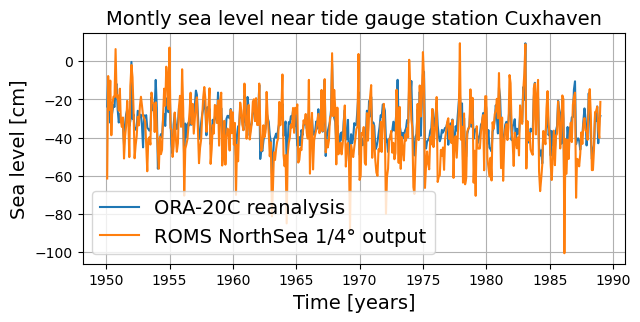

In [50]:
stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Brest', 'Sheerness', 'Cuxhaven']

for station in stations:

    plt.figure(figsize = (7,3))

    
    # Select data near station
    if station == 'Vlissingen':
        
        ora_station = ora20cm.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_monthly.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        
    elif station == 'Hoek v. Holland':
        
        ora_station = ora20cm.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.2, method = 'Nearest')
        roms_station = roms_monthly.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        
    elif station == 'Den Helder':
        
        ora_station = ora20cm.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_monthly.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
            
    elif station == 'Delfzijl': 
        
        ora_station = ora20cm.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_monthly.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
    
    elif station == 'Harlingen': 
        
        ora_station = ora20cm.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_monthly.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
           
    elif station == 'Brest': 
        
        ora_station = ora20cm.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_monthly.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
           
    elif station == 'Sheerness': 
        
        ora_station = ora20cm.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_monthly.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
    
    elif station == 'Cuxhaven': 
        
        ora_station = ora20cm.sel(latitude = tg_coords['lat'][station]+0.5, longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_monthly.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        
    else:
         
        ora_station = ora20cm.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        roms_station = roms_monthly.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')

    # Make data shorter period
    ora_station = ora_station.where((ora_station.time.dt.year > 1949) & (ora_station.time.dt.year < 1991), drop = True)
   

    # Plot data
    plt.plot(ora_station.time, ora_station.zos*100)
    plt.plot(roms_station.time, roms_station.zeta*100)


    # Format figure
    fsize = 14

    plt.xlabel('Time [years]', fontsize = fsize)
    plt.ylabel('Sea level [cm]', fontsize = fsize)
    plt.title(f'Montly sea level near tide gauge station {station}', fontsize = fsize)

    #plt.xlim([1950, 2020])
    #plt.xticks([1960, 1980, 2000, 2020], fontsize = fsize)
    #plt.yticks([-40, -20], fontsize = fsize)

    plt.grid()


    # Add legend
    plt.legend(labels = ['ORA-20C reanalysis', 'ROMS NorthSea 1/4° output'], fontsize = fsize)

    if station == 'Hoek v. Holland':
        plt.savefig(f'figures/ora_roms_tidegauges_HoekvHolland')
    else:
        plt.savefig(f'figures/ora_roms_tidegauges_{station}')


## Compare regional mean

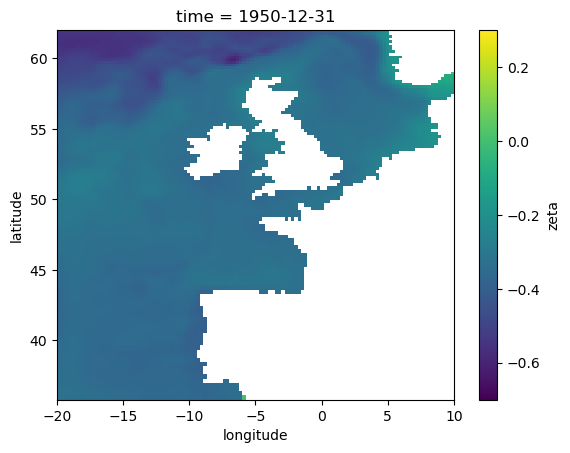

In [51]:
roms_yearly.zeta.isel(time=0).plot(vmin = -0.7, vmax = 0.3)
plt.savefig('figures/roms_yearly_zeta_surface_1950')

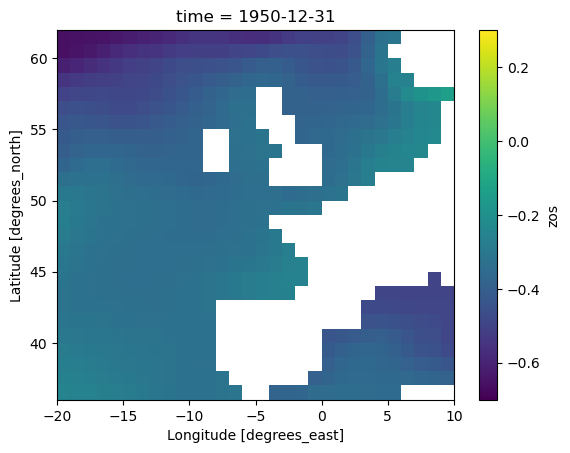

In [52]:
ora20cy = ora20cy.where((ora20cy.longitude < 10) & (ora20cy.longitude > -20) & (ora20cy.latitude < 62) & (ora20cy.latitude > 36), drop = True)

ora20cy.zos.isel(time=0).plot(vmin = -0.7, vmax = 0.3)
plt.savefig('figures/ora_yearly_zos_surface_1950')

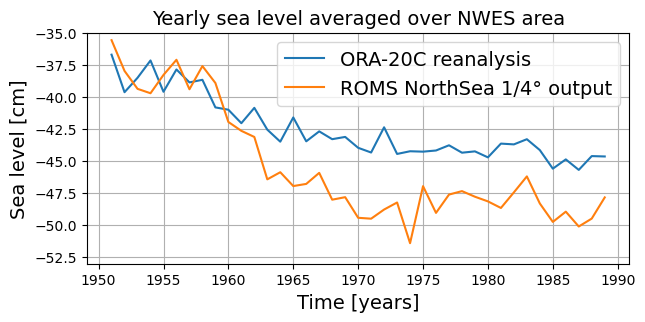

In [53]:
plt.figure(figsize = (7,3))

ora_weights = np.cos(np.deg2rad(ora20cy.latitude))
ora20c_weighted = ora20cy.weighted(ora_weights)

roms_weights = np.cos(np.deg2rad(roms_yearly.latitude))
roms_weighted = roms_yearly.weighted(roms_weights)

ora_area = ora20c_weighted.mean(['latitude', 'longitude'])
roms_area = roms_weighted.mean(['latitude', 'longitude'])


# Plot data
plt.plot(ora_area.time, ora_area.zos*100)
plt.plot(roms_area.time, roms_area.zeta*100)


# Format figure
fsize = 14

plt.xlabel('Time [years]', fontsize = fsize)
plt.ylabel('Sea level [cm]', fontsize = fsize)
plt.title(f'Yearly sea level averaged over NWES area', fontsize = fsize)

plt.ylim([-53, -35])
#plt.xlim([1950, 2020])
#plt.xticks([1960, 1980, 2000, 2020], fontsize = fsize)
#plt.yticks([-50, -45, -40, -35], fontsize = fsize)

plt.grid()


# Add legend
plt.legend(labels = ['ORA-20C reanalysis', 'ROMS NorthSea 1/4° output'], fontsize = fsize)

plt.savefig('figures/roms_ora_region_average_weighted')

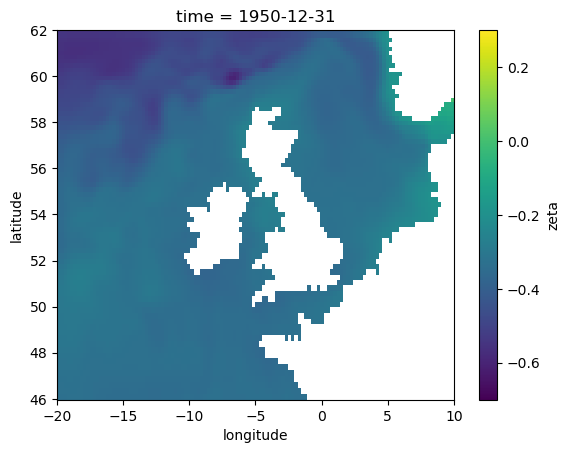

In [54]:
roms_yearly.zeta.isel(time=0).where(roms_yearly.latitude > 46, drop = True).plot(vmin = -0.7, vmax = 0.3)
plt.savefig('figures/roms_yearly_zeta_surface_1950')

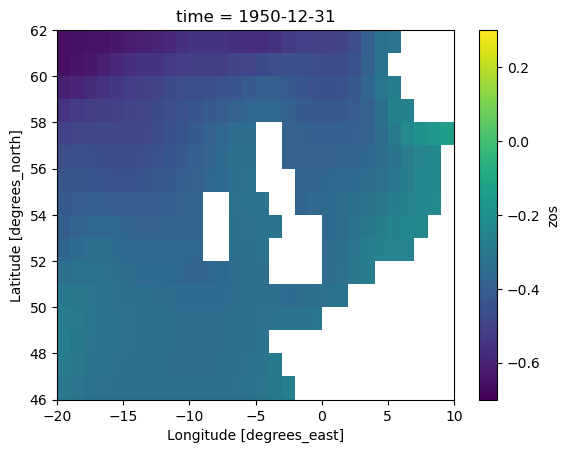

In [55]:
ora20cy = ora20cy.where((ora20cy.longitude < 10) & (ora20cy.longitude > -20) & (ora20cy.latitude < 62) & (ora20cy.latitude > 46), drop = True)

ora20cy.zos.isel(time=0).plot(vmin = -0.7, vmax = 0.3)
plt.savefig('figures/ora_yearly_zos_surface_1950')

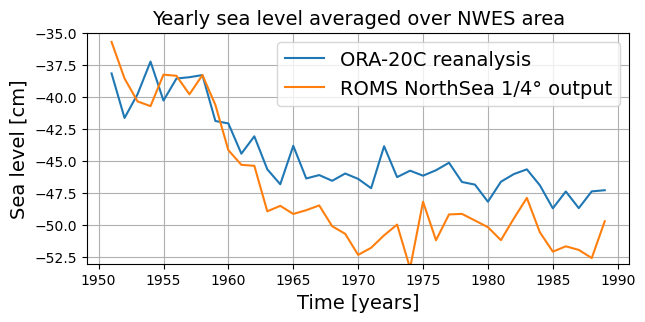

In [56]:
plt.figure(figsize = (7,3))

ora_weights = np.cos(np.deg2rad(ora20cy.latitude))
ora20c_weighted = ora20cy.weighted(ora_weights)

roms_weights = np.cos(np.deg2rad(roms_yearly.where(roms_yearly.latitude > 46, drop = True).latitude))
roms_weighted = roms_yearly.where(roms_yearly.latitude > 46, drop = True).weighted(roms_weights)

ora_area = ora20c_weighted.mean(['latitude', 'longitude'])
roms_area = roms_weighted.mean(['latitude', 'longitude'])


# Plot data
plt.plot(ora_area.time, ora_area.zos*100)
plt.plot(roms_area.time, roms_area.zeta*100)


# Format figure
fsize = 14

plt.xlabel('Time [years]', fontsize = fsize)
plt.ylabel('Sea level [cm]', fontsize = fsize)
plt.title(f'Yearly sea level averaged over NWES area', fontsize = fsize)

plt.ylim([-53, -35])
#plt.xlim([1950, 2020])
#plt.xticks([1960, 1980, 2000, 2020], fontsize = fsize)
#plt.yticks([-50, -45, -40, -35], fontsize = fsize)

plt.grid()


# Add legend
plt.legend(labels = ['ORA-20C reanalysis', 'ROMS NorthSea 1/4° output'], fontsize = fsize)

plt.savefig('figures/roms_ora_region_average_weighted')

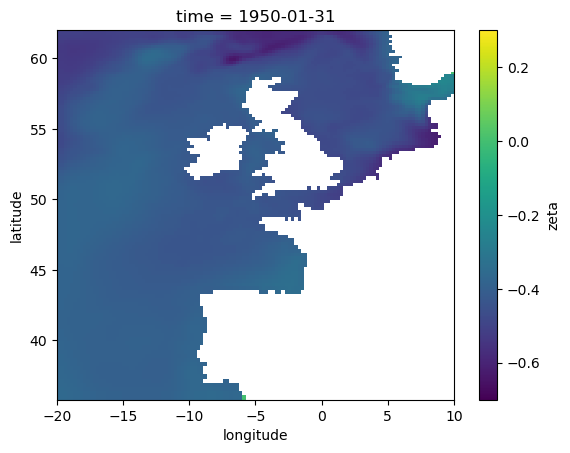

In [57]:
roms_monthly.zeta.isel(time=0).plot(vmin = -0.7, vmax = 0.3)
plt.savefig('figures/roms_monthly_zeta_surface_1950')

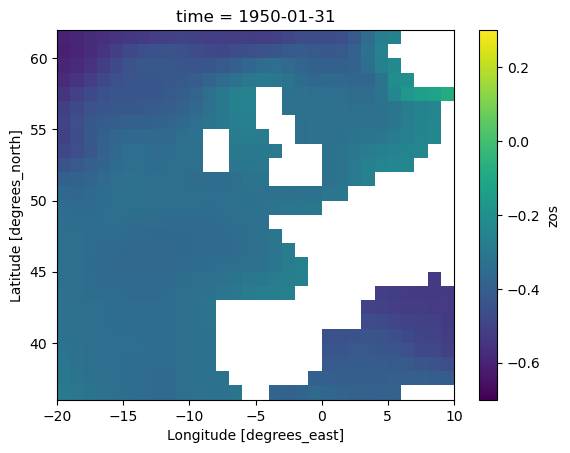

In [58]:
ora20cm = ora20cm.where((ora20cm.longitude < 10) & (ora20cm.longitude > -20) & (ora20cm.latitude < 62) & (ora20cm.latitude > 36), drop = True)

ora20cm.zos.isel(time=0).plot(vmin = -0.7, vmax = 0.3)
plt.savefig('figures/ora_monthly_zos_surface_1950')

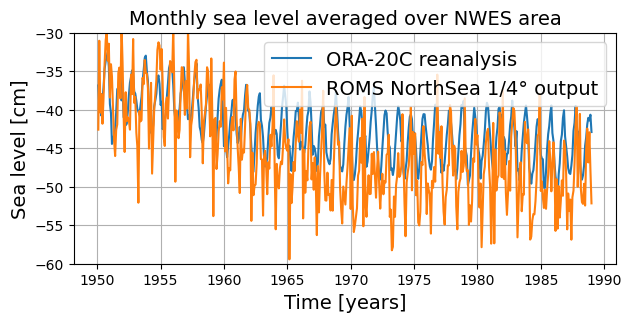

In [59]:
plt.figure(figsize = (7,3))

ora_weights = np.cos(np.deg2rad(ora20cm.latitude))
ora20c_weighted = ora20cm.weighted(ora_weights)

roms_weights = np.cos(np.deg2rad(roms_monthly.latitude))
roms_weighted = roms_monthly.weighted(roms_weights)

ora_area = ora20c_weighted.mean(['latitude', 'longitude'])
roms_area = roms_weighted.mean(['latitude', 'longitude'])


# Plot data
plt.plot(ora_area.time, ora_area.zos*100)
plt.plot(roms_area.time, roms_area.zeta*100)


# Format figure
fsize = 14

plt.xlabel('Time [years]', fontsize = fsize)
plt.ylabel('Sea level [cm]', fontsize = fsize)
plt.title(f'Monthly sea level averaged over NWES area', fontsize = fsize)

plt.ylim([-60, -30])
#plt.xlim([1950, 2020])
#plt.xticks([1960, 1980, 2000, 2020], fontsize = fsize)
#plt.yticks([-50, -45, -40, -35], fontsize = fsize)

plt.grid()


# Add legend
plt.legend(labels = ['ORA-20C reanalysis', 'ROMS NorthSea 1/4° output'], fontsize = fsize)

plt.savefig('figures/roms_ora_region_average_weighted')

## Compare volume flux to sea level

ROMS output is 5day values of sea level and ubar and vbar 


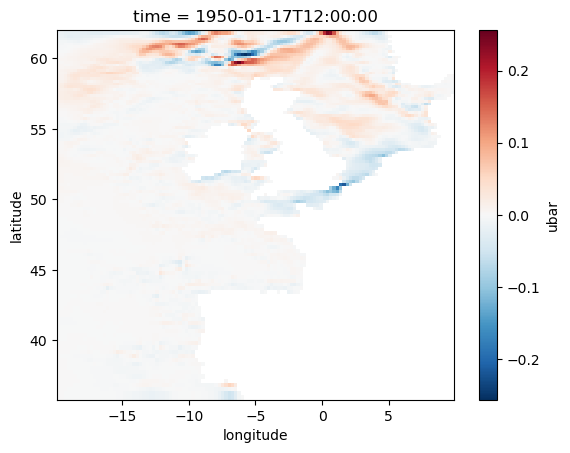

In [60]:
roms_u.ubar.isel(time=0).plot()

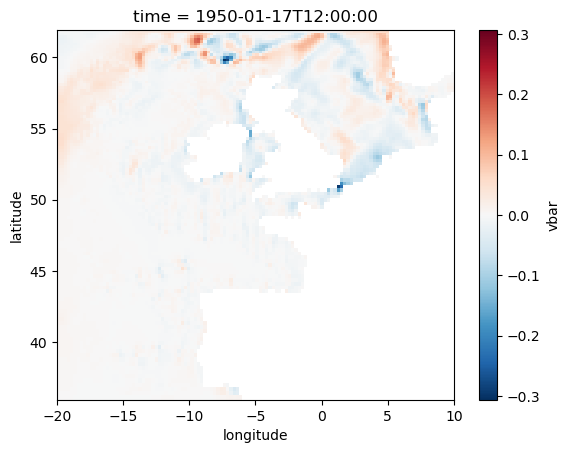

In [61]:
roms_v.vbar.isel(time=0).plot()

In [62]:
# Obtain for each boundary ubar and vbar

roms_ubar_west = roms_u.ubar.isel(longitude=0, drop = True)
roms_ubar_east = roms_u.ubar.isel(longitude=-1, drop = True)
roms_vbar_north = roms_v.vbar.isel(latitude=-1, drop = True)
roms_vbar_south = roms_v.vbar.isel(latitude=0, drop = True)



In [63]:
# Obtain for each grid point along boundary the depth (dz)
roms_dz_west = roms_rho.h.isel(longitude = 0, drop = True) + roms_rho.zeta.isel(longitude = 0, drop = True)
roms_dz_east = roms_rho.h.isel(longitude = -1, drop = True) + roms_rho.zeta.isel(longitude = -1, drop = True)
roms_dz_south = roms_rho.h.isel(latitude = 0, drop = True) + roms_rho.zeta.isel(latitude = 0, drop = True)
roms_dz_north = roms_rho.h.isel(latitude = -1, drop = True) + roms_rho.zeta.isel(latitude = -1, drop = True)




In [64]:
# Obtain for each grid point ubar/vbar multiplied by dz and obtain the sum along the boundary
roms_ubardz_west = roms_ubar_west*roms_dz_west
roms_ubardz_east = roms_ubar_east*roms_dz_east
roms_vbardz_south = roms_vbar_south*roms_dz_south
roms_vbardz_north = roms_vbar_north*roms_dz_north


roms_ubardz_west = roms_ubardz_west.sum('latitude')
roms_ubardz_east = roms_ubardz_east.sum('latitude')
roms_vbardz_south = roms_vbardz_south.sum('longitude')
roms_vbardz_north = roms_vbardz_north.sum('longitude')


In [65]:
# Obtain for each boundary the width (dx or dy)

roms_dy_west = geopy.distance.geodesic((roms_rho.latitude.values[0], roms_rho.longitude.values[0]), (roms_rho.latitude.values[-1], roms_rho.longitude.values[0])).m
roms_dy_east = geopy.distance.geodesic((roms_rho.latitude.values[0], roms_rho.longitude.values[-1]), (roms_rho.latitude.values[-1], roms_rho.longitude.values[-1])).m
roms_dx_south = geopy.distance.geodesic((roms_rho.latitude.values[0], roms_rho.longitude.values[0]), (roms_rho.latitude.values[0], roms_rho.longitude.values[-1])).m
roms_dx_north = geopy.distance.geodesic((roms_rho.latitude.values[-1], roms_rho.longitude.values[0]), (roms_rho.latitude.values[-1], roms_rho.longitude.values[-1])).m


In [66]:
# Multiply for each boundary ubar*dz with the width
roms_ubardzdy_west = roms_ubardz_west*roms_dy_west
roms_ubardzdy_east = roms_ubardz_east*roms_dy_east
roms_vbardzdx_south = roms_vbardz_south*roms_dx_south
roms_vbardzdx_north = roms_vbardz_north*roms_dx_north

In [67]:
# The sample frequency is 5 days 
freq = 1/(5*24*3600)

# Divide by sample frequency to get inflow or outflow per boundary in m^3
roms_vol_west = roms_ubardzdy_west * freq
roms_vol_east = roms_ubardzdy_east * freq
roms_vol_south = roms_vbardzdx_south * freq
roms_vol_north = roms_vbardzdx_north * freq

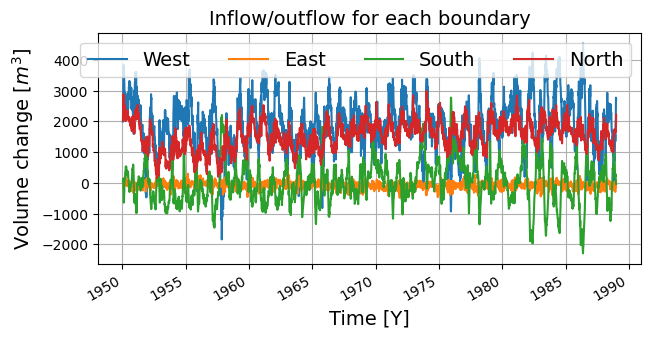

In [68]:
plt.figure(figsize=(7,3))

roms_vol_west.plot()
roms_vol_east.plot()
roms_vol_south.plot()
roms_vol_north.plot()

# Format figure
fsize = 14

plt.xlabel('Time [Y]', fontsize = fsize)
plt.ylabel('Volume change [$m^3$]', fontsize = fsize)
plt.title('Inflow/outflow for each boundary', fontsize = fsize)

plt.grid()

# Add legend
plt.legend(labels = ['West', 'East', 'South', 'North'], fontsize = fsize, ncol=4)

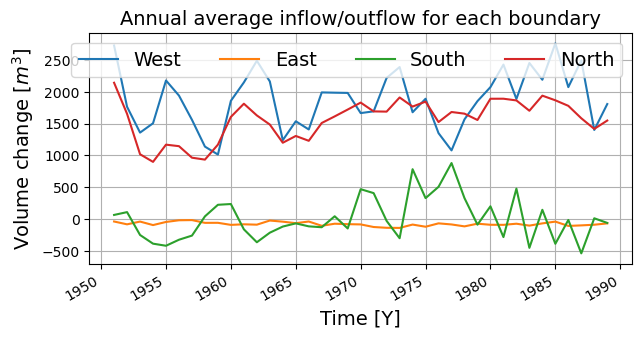

In [69]:
plt.figure(figsize=(7,3))

roms_vol_west.resample(time='1Y').mean().plot()
roms_vol_east.resample(time='1Y').mean().plot()
roms_vol_south.resample(time='1Y').mean().plot()
roms_vol_north.resample(time='1Y').mean().plot()

# Format figure
fsize = 14

plt.xlabel('Time [Y]', fontsize = fsize)
plt.ylabel('Volume change [$m^3$]', fontsize = fsize)
plt.title('Annual average inflow/outflow for each boundary', fontsize = fsize)

plt.grid()

# Add legend
plt.legend(labels = ['West', 'East', 'South', 'North'], fontsize = fsize, ncol=4)

In [70]:
# Obtain total inflow/outflow 
roms_vol = roms_vol_west + roms_vol_east + roms_vol_south + roms_vol_north # m^3

In [71]:
# Divide by surface area
roms_area = (roms_dy_west + roms_dy_east)/2 * (roms_dx_south + roms_dx_north)/2

In [72]:
# Obtain area average change
roms_area_average_change = roms_vol / roms_area   # m

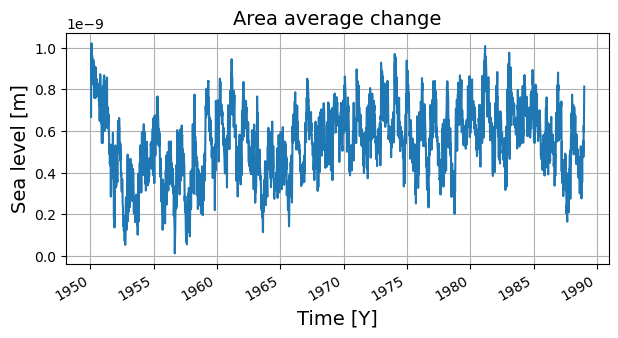

In [73]:
plt.figure(figsize=(7,3))

roms_area_average_change.plot()

# Format figure
fsize = 14

plt.xlabel('Time [Y]', fontsize = fsize)
plt.ylabel('Sea level [m]', fontsize = fsize)
plt.title('Area average change', fontsize = fsize)

plt.grid()



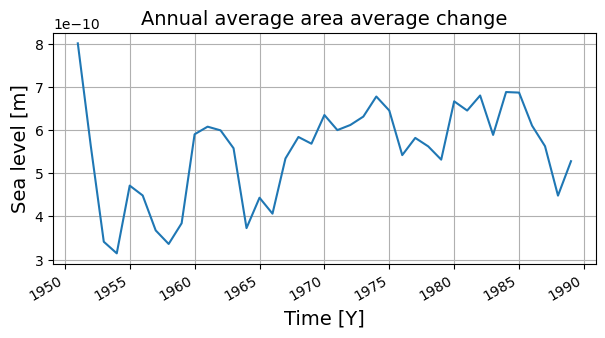

In [74]:
plt.figure(figsize=(7,3))

roms_area_average_change.resample(time='1Y').mean().plot()

# Format figure
fsize = 14

plt.xlabel('Time [Y]', fontsize = fsize)
plt.ylabel('Sea level [m]', fontsize = fsize)
plt.title('Annual average area average change', fontsize = fsize)

plt.grid()



#### Obtain the same for ORA

In [75]:
def integrate_1D(data, depths):
    
    mom = 0.0 
    depth_prev = 0.0
    
    for z in range(len(depths)):
        
        if np.isnan(data[z]):
            mom = mom
            
        else:
            mom = mom + data[z] * abs(depths[z] - depth_prev)
            
        depth_prev = depths[z]
        
    return np.asarray(mom/depths[-1])


# Calculate UBAR
ora_UBAR = xr.apply_ufunc(integrate_1D, 
                      ora20c.uo, ora20c.depth,
                      input_core_dims=[['depth'], ['depth']],
                      exclude_dims=set(('depth',)),
                      dask = 'parallelized',
                      output_dtypes = [ora20c.uo.dtype],
                      vectorize = True)


# Calculate VBAR
ora_VBAR = xr.apply_ufunc(integrate_1D, 
                      ora20c.vo, ora20c.depth,
                      input_core_dims=[['depth'], ['depth']],
                      exclude_dims=set(('depth',)),
                      dask = 'parallelized',
                      output_dtypes = [ora20c.vo.dtype],
                      vectorize = True)

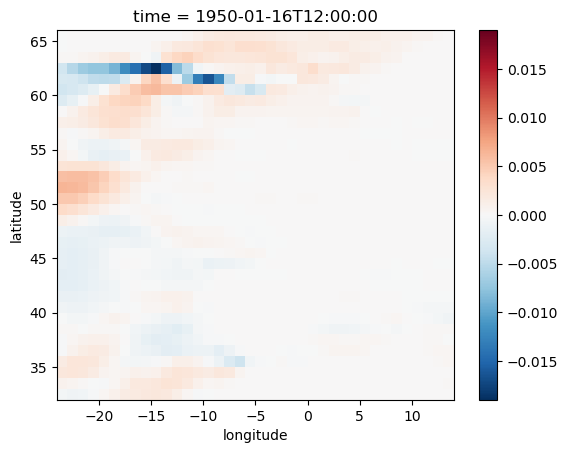

In [76]:
ora_UBAR.isel(time=0).plot()

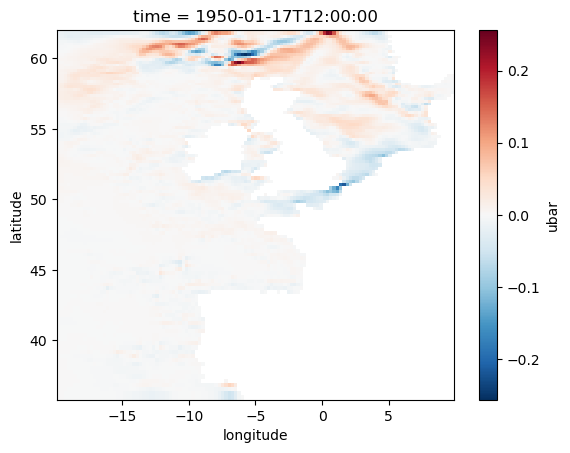

In [77]:
roms_u.ubar.isel(time=0).plot()

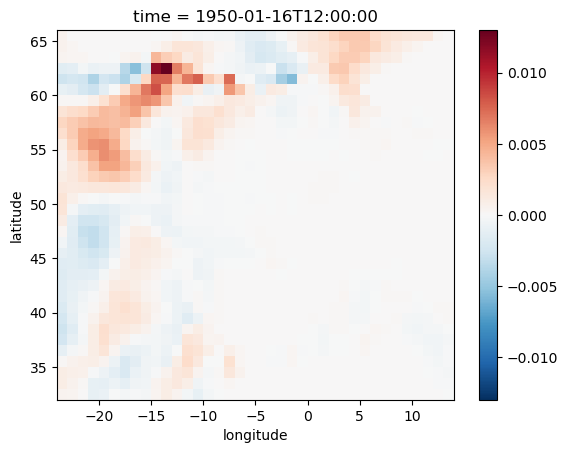

In [78]:
ora_VBAR.isel(time=0).plot()

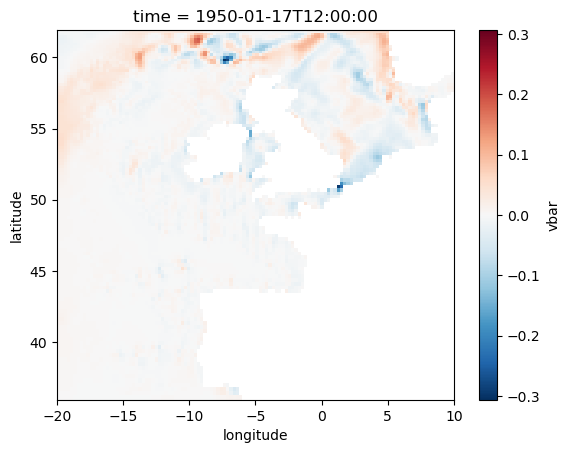

In [79]:
roms_v.vbar.isel(time=0).plot()

In [80]:
# Obtain for each boundary ubar and vbar

ora_ubar_west = ora_UBAR.isel(longitude=0, drop = True)
ora_ubar_east = ora_UBAR.isel(longitude=-1, drop = True)
ora_vbar_north = ora_VBAR.isel(latitude=-1, drop = True)
ora_vbar_south = ora_VBAR.isel(latitude=0, drop = True)

In [81]:
# Obtain for each grid point along boundary the depth (dz) mean sea-level to bottom + zeta

# THIS IS NOT STRAIGHTFORWARD

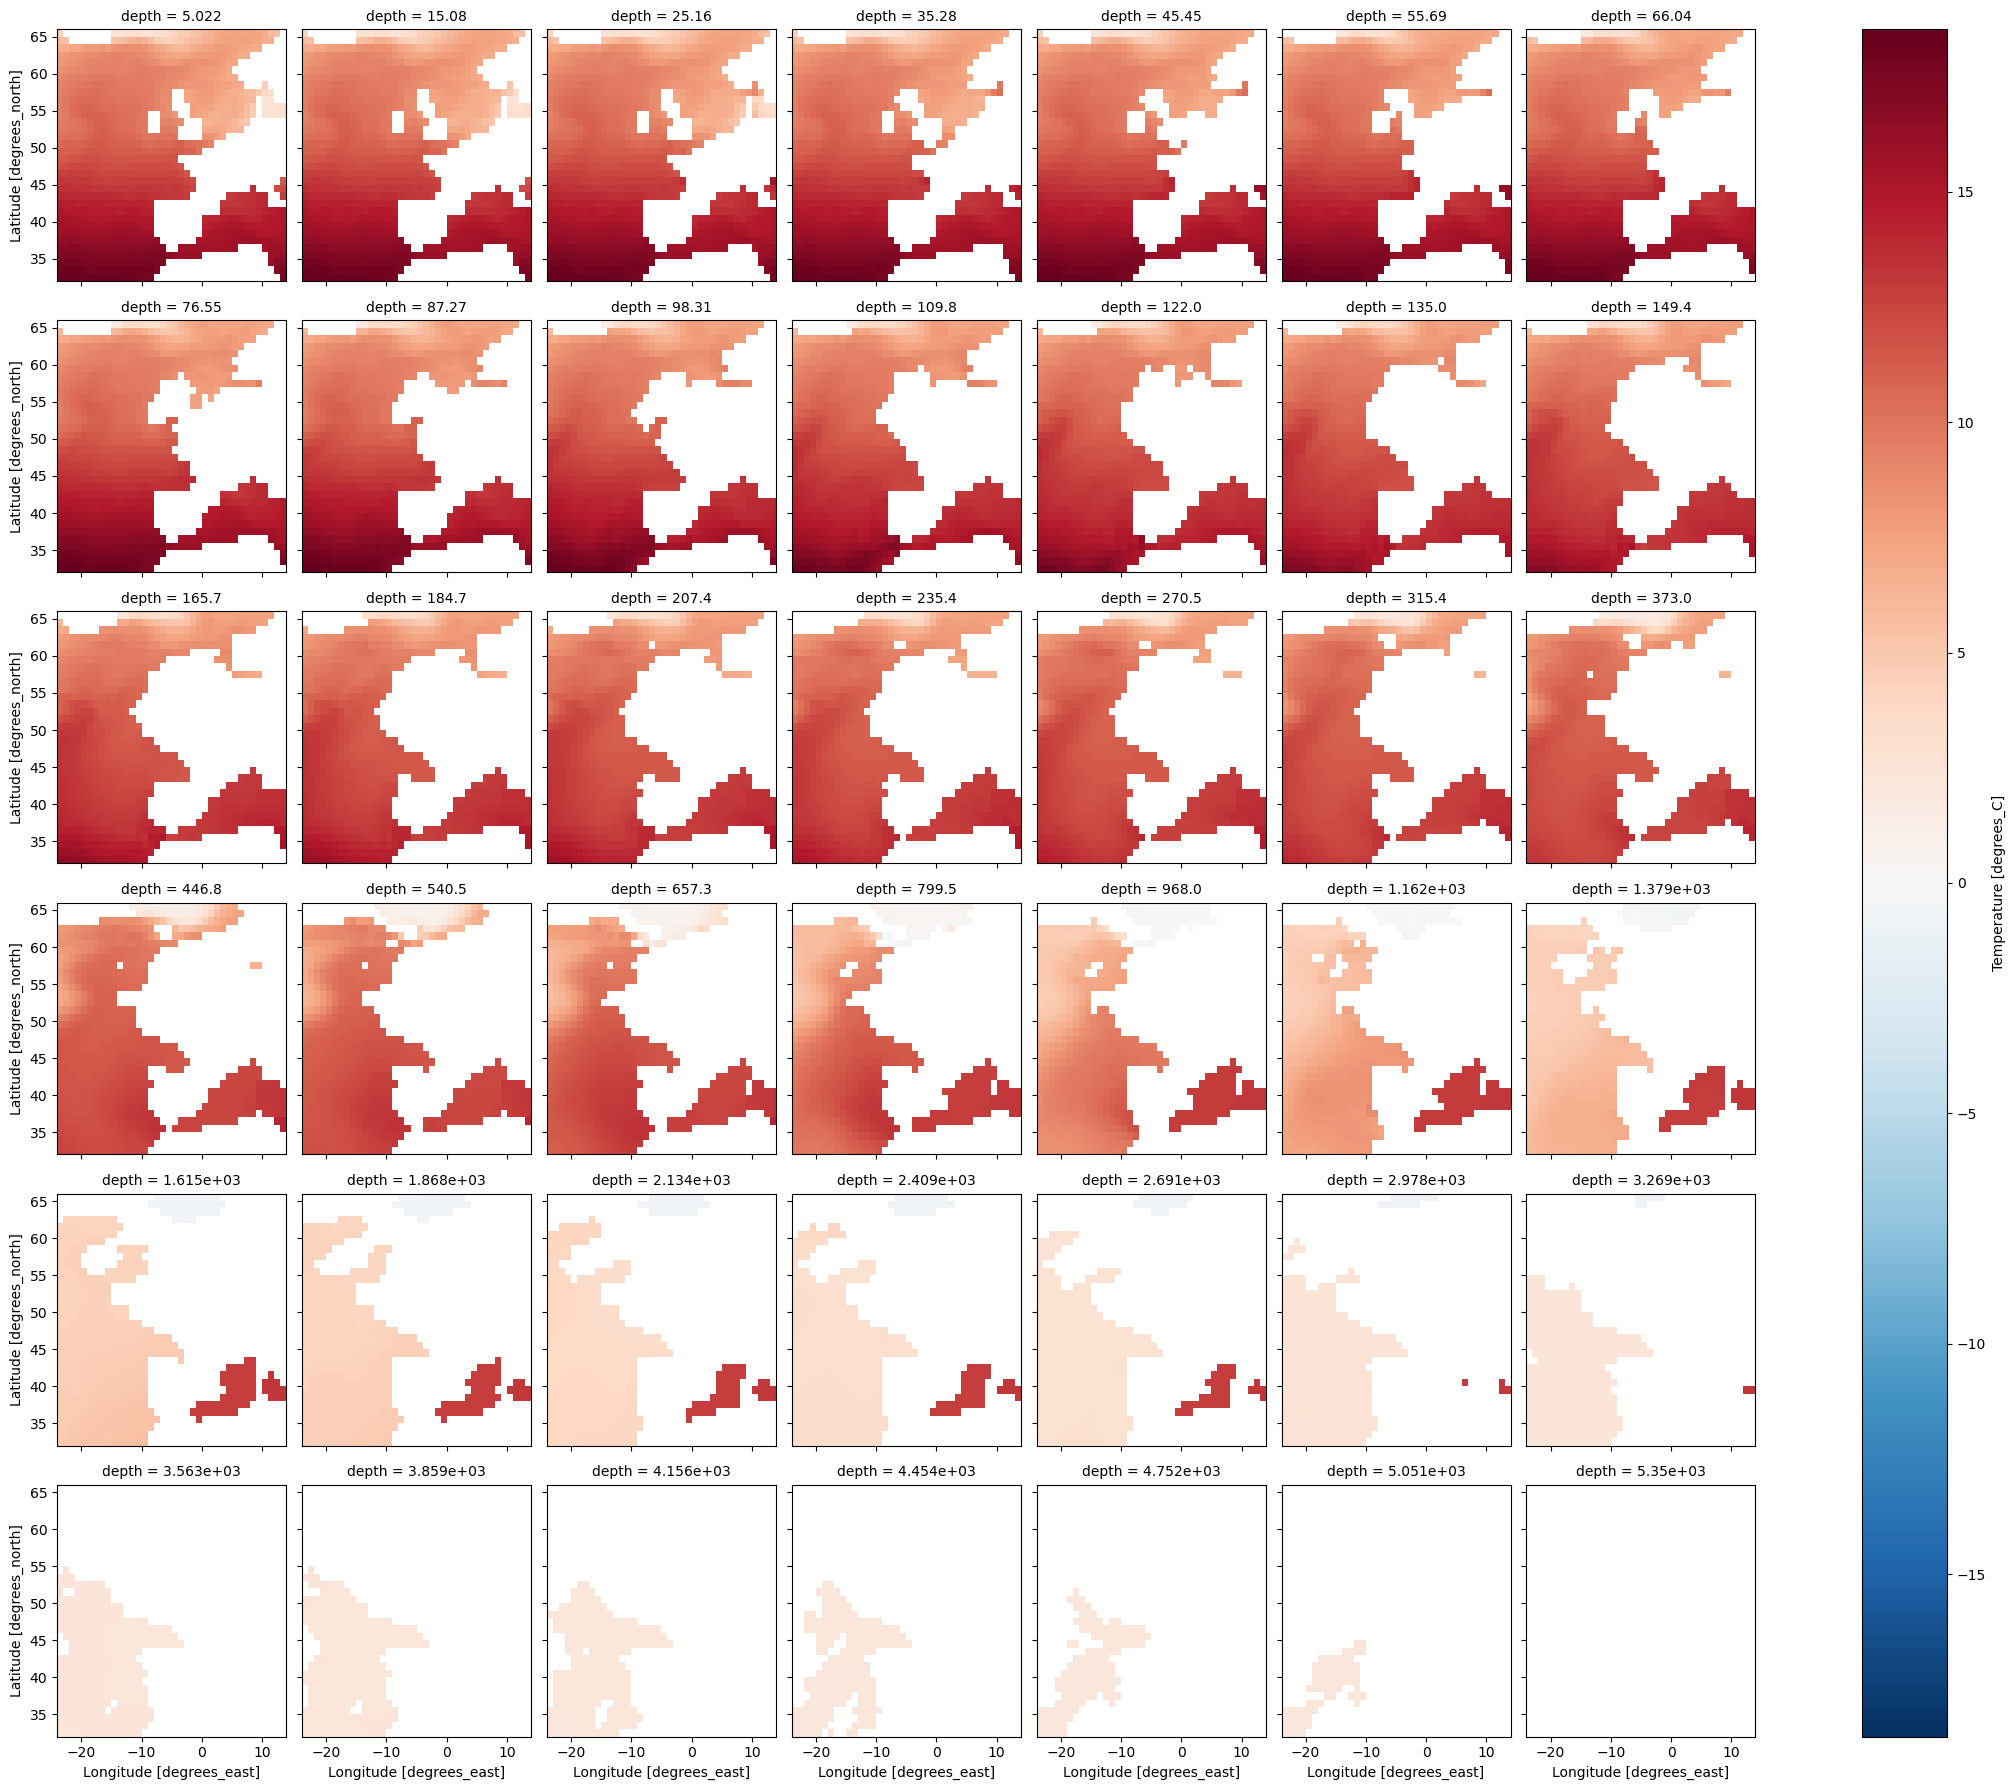

In [82]:
ora20c.thetao.isel(time=0).plot(col='depth', col_wrap = 7)